In [46]:
import pandas as pd
import nltk
import nltk.data
from nltk.tokenize import word_tokenize
import numpy as np
from convokit import Corpus, download, FightingWords, Utterance, Speaker
from collections import Counter, defaultdict
from torchtext.vocab import GloVe
from utils.corpus import get_corpus
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics
import ast
import matplotlib.pyplot as plt

In [2]:
def corpus_from_source(source, field, n):
    if isinstance(source, str)
        df, _  = get_corpus(source, text_field=field, split_sentences=True, punct=False, to_ascii=True,
                    min_len=3, max_len=15,  test_size=0.0001, subsample_rows=n, save=False)
    else:
        df =
    speaker = Speaker(meta={'name': source})
    utts = [Utterance(id=f'{source}{i}', text=' '.join(t), speaker=speaker) for i, t in enumerate(df.utterance) ]
    corp = Corpus(utterances=utts)
    return df, corp

def compare_corpora(c1, c2, n1, n2):
    print(n1)
    c1.print_summary_stats()
    print(c1.get_utterances_dataframe().text.map(lambda x: x.split()).map(len).describe())
    print('\n'.join(c1.random_utterance().text for _ in range(10)))
    print('\n')
    print(n2)
    c2.print_summary_stats()
    print(c2.get_utterances_dataframe().text.map(lambda x: x.split()).map(len).describe())
    print('\n'.join(c2.random_utterance().text for _ in range(10)))
    ids1 = set(c1.get_utterance_ids())
    corp = c1.merge(c2)
    fw = FightingWords(ngram_range=(1,1))
    fw.fit(corp, class1_func=lambda utt: utt.id in ids1, 
                 class2_func=lambda utt: utt.id not in ids1)
    print(fw.summarize(corp, plot=False, class1_name=n1,
                                          class2_name=n2))
    return fw
    
def run_comparison(source1, field1, source2, field2, n=1000):
    print('loading ', source1)
    df1, c1 = corpus_from_source(source1, field1, n)
    print('loading ', source2)
    df2, c2 = corpus_from_source(source2, field2, n)
    return df1, df2, compare_corpora(c1, c2, source1, source2)

def word_freqs_in_vocab(data, voc, n=1000):
    return Counter(w if w in voc else 'unk' for s in data.iloc[:n] for w in s)

def word_freqs(data, n=1000):
    return Counter(w for s in data.iloc[:n] for w in s)

In [3]:
# imdb = pd.read_csv('data_options/IMDB Dataset.csv')
# food = pd.read_csv('data_options/Reviews.csv')
# movies = pd.read_csv('data_options/movies_metadata.csv')
# tmbd = pd.read_csv('data_options/tmdb_5000_movies.csv')
# hotels = pd.read_csv('data_options/tripadvisor_hotel_reviews.csv')

In [7]:
with open('data/google-10000-english-usa.txt', 'r') as fh:
    vocab10k = set(t.strip() for t in fh.readlines())
g = GloVe('6B',dim=50, cache='data')
glove_vocab = set(g.stoi)

In [8]:
general_word_freqs = pd.read_csv('data/unigram_freq.csv')

In [9]:
n = 50000

In [11]:
df1, df2, fw = run_comparison('parliament-corpus', 'text', 'friends-corpus', 'text', n=n)

loading  parliament-corpus
Dataset already exists at /Users/janek/.convokit/downloads/parliament-corpus
Cleaning
44946
5
loading  friends-corpus
Dataset already exists at /Users/janek/.convokit/downloads/friends-corpus
Cleaning
50428
6
parliament-corpus
Number of Speakers: 1
Number of Utterances: 44946
Number of Conversations: 1
count    44946.000000
mean        10.380835
std          3.293194
min          3.000000
25%          8.000000
50%         11.000000
75%         13.000000
max         15.000000
Name: text, dtype: float64
i agree entirely with my hon friend
one needs to determine eligibility and damage
i refer my hon friend to the reply that i gave some moments ago
we are spending about double what they wanted on for example education and health
that is a good deal and we should stick with it
i agree absolutely with my hon friend who has much experience in this area
changing the system is not the easiest thing in the world
we would like cyprus to join as soon as possible
we are p

In [12]:
df1.shape, df2.shape

((44946, 1), (50428, 1))

In [13]:
c1 = word_freqs(df1.utterance, n=n)
c1v = word_freqs_in_vocab(df1.utterance, voc=glove_vocab, n=n)
c1v10k = word_freqs_in_vocab(df1.utterance, voc=vocab10k, n=n)
c2 = word_freqs(df2.utterance, n=n)
c2v = word_freqs_in_vocab(df2.utterance, voc=glove_vocab, n=n)
c2v10k = word_freqs_in_vocab(df2.utterance, voc=vocab10k, n=n)

In [14]:
# out of vocab
c1v['unk']/sum(c1.values()), c2v['unk']/sum(c2.values()), c1v10k['unk'], c2v10k['unk']

(0.0009666142994618252, 0.006785587550524066, 30273, 44612)

In [15]:

len(c1.keys()), len(c2.keys()), len(set(c1.keys()) - set(c2.keys())), len(set(c2.keys()) - set(c1.keys()))

(14777, 11088, 10051, 6362)

In [16]:
oov1 = 0
for key in set(c1.keys()) - set(c2.keys()):
    oov1 += c1[key]
    if c1[key] > 15:
        print(key, c1[key])
oov1/sum(c1.values())

merely 25
raises 184
consultations 16
implications 23
citizens 29
continued 28
examining 23
remarkable 27
deficit 40
arts 46
employed 20
surplus 19
trusts 30
downing 17
charges 47
welcoming 19
thoroughly 23
nearly 52
detailed 40
depend 31
relevant 42
maintain 35
sectors 17
staff 78
rising 40
experienced 16
greatly 40
selective 16
economic 142
produced 34
regard 100
parliamentary 36
enable 27
answered 41
provided 74
crucial 46
enforcement 20
1980 22
funding 171
allies 19
effect 103
madam 33
completed 24
recognised 20
crown 29
1974 16
recognise 183
extended 31
achievement 29
difficulties 91
whereas 27
drawn 21
shortage 21
employment 131
defra 16
70 63
charter 20
border 17
publish 55
chancellor 162
wholly 50
railway 20
reduction 86
assurance 162
liverpool 20
justify 23
strategic 24
promises 16
penalties 16
elections 27
bearing 18
satisfactory 30
reforms 36
complaints 25
compensation 28
alternative 22
prisons 36
centre 41
represented 21
links 18
charities 19
undertaken 20
accommodation 21


0.11795480703077948

In [17]:
oov2 = 0
for key in set(c2.keys()) - set(c1.keys()):
    oov2 += c2[key]
    if c2[key] > 20:
        print(key, c2[key])
oov2/sum(c2.values())

whoa 204
underwear 33
shoes 35
dad 150
vegas 24
'd 457
loves 31
drunk 49
guys 784
charlie 40
bathroom 62
fake 25
hey 1365
emma 111
scary 21
ben 95
gotten 22
honey 245
pheebs 187
sec 25
hmm 48
'cause 189
rach 199
hates 25
pee 24
bird 23
wh 76
dollars 62
buffay 31
romantic 29
damn 29
marcel 35
drake 34
dating 35
juice 22
kid 54
aw 24
smell 53
cookie 21
favorite 36
chick 28
um 251
bucks 41
kidding 114
ho 74
c'mon 72
kathy 21
joe 70
idiot 24
naked 86
lauren 22
sing 23
ate 26
ralph 27
freak 35
coat 33
jack 36
movie 87
wha 27
tribbiani 46
dancing 27
soo 27
uhm 71
realize 26
yourself 94
forever 30
gunther 30
eh 39
ha 90
yep 21
dressed 34
aww 25
dress 45
blah 22
anymore 108
actor 44
ass 70
umm 371
yeah 1823
sweetie 64
bitch 32
sandwich 36
girlfriend 54
oooh 21
pete 23
tulsa 24
apartment 129
pizza 39
chef 29
yours 55
cool 122
santa 26
carol 53
gosh 22
wear 67
kinda 199
la 55
ahh 68
daddy 36
buddy 45
wan 438
shower 34
kissing 27
cute 100
doin 68
uh 1247
ya 300
ow 57
pants 76
mona 26
bye 115
mass

0.10065288199944031

# Parliament vs Friends

In [ ]:
s1 = 'parliament-corpus'
s2 = 'friends-corpus'

In [35]:
train1, val1, _, _ = get_corpus(s1, text_field='text', split_sentences=True, punct=False, to_ascii=True,
                    min_len=3, max_len=15,  test_size=0.1, subsample_rows=False, save=False)
train2, val2, _, _ = get_corpus(s2, text_field='text', split_sentences=True, punct=False, to_ascii=True,
                    min_len=3, max_len=15,  test_size=0.1, subsample_rows=False, save=False)

Loading cached data...
353386
39266
Loading cached data...
61260
6807


## Baseline 1: frequency based likelihoods

In [49]:
total_vocab = list(set(w for df in [train1, val1, train2, val2] for utt in df.utterance.apply(ast.literal_eval) for w in utt))

In [51]:
total_vocab[0], len(total_vocab)

('merely', 39428)

In [74]:
eps = 1e-8
vect = CountVectorizer(ngram_range=(1,1), analyzer='word', vocabulary=total_vocab, token_pattern = r"(?u)\b\w+\b")
v1 = vect.transform(train1.utterance.apply(ast.literal_eval).apply(' '.join))
v1 = v1[v1.getnnz(1)>0][:n]
v2 = vect.transform(train2.utterance.apply(ast.literal_eval).apply(' '.join))
v2 = v2[v2.getnnz(1)>0][:n]
freq1 = v1.sum(axis=0)[0]/v1.sum() + eps
freq2 = v2.sum(axis=0)[0]/v2.sum() + eps


In [75]:
v1_val = vect.transform(val1.utterance.apply(ast.literal_eval).apply(' '.join))
v2_val = vect.transform(val2.utterance.apply(ast.literal_eval).apply(' '.join))

In [76]:
tmp = val2.utterance.apply(ast.literal_eval).apply(' '.join)

In [79]:
vect.transform([tmp.iloc[542]]).sum()

4

In [78]:
vect.transform(['n']).sum()

1

In [80]:
freq_dict = defaultdict(int, general_word_freqs.set_index('word')['count'].to_dict())
general_freq = np.array([freq_dict[w] for w in total_vocab])
general_freq = general_freq/sum(general_freq) + eps

In [81]:
def get_log_likelihoods(vectorized, frequencies): # normalized by length
    w = vectorized.multiply(frequencies).tocsr()
    log_likes = []
    for i in range(w.shape[0]):
        _, ind = w[i].nonzero()
        if len(ind) == 0:
            print(i)
            raise Exception
        log_likes.append(sum(np.log(w[i,j]) for j in ind)/len(ind))
    print('done')
    return np.array(log_likes)

In [82]:
ll1_f1 = get_log_likelihoods(v1_val, freq1) # likelihoods of samples in 1 given frequencies in 1
ll2_f1 = get_log_likelihoods(v2_val, freq1) # likelihoods of samples in 2 given frequencies in 1
ll1_f2 = get_log_likelihoods(v1_val, freq2) 
ll2_f2 = get_log_likelihoods(v2_val, freq2) 
ll1_general = get_log_likelihoods(v1_val, general_freq) 
ll2_general = get_log_likelihoods(v2_val, general_freq) 

done
done
done
done
done
done


In [83]:
pd.Series(ll1_general).describe(), pd.Series(ll2_general).describe()

(count    39266.000000
 mean        -7.441175
 std          0.938275
 min        -15.511743
 25%         -7.853623
 50%         -7.326176
 75%         -6.864247
 max         -4.642308
 dtype: float64,
 count    6807.000000
 mean       -7.402081
 std         1.042699
 min       -15.598854
 25%        -7.847755
 50%        -7.254592
 75%        -6.732997
 max        -4.300310
 dtype: float64)

In [84]:
pd.Series(ll1_f1).describe(), pd.Series(ll2_f1).describe()

(count    39266.000000
 mean        -6.465658
 std          1.058968
 min        -15.190386
 25%         -7.047859
 50%         -6.423630
 75%         -5.766665
 max         -3.837535
 dtype: float64,
 count    6807.000000
 mean       -8.274839
 std         1.907507
 min       -18.420681
 25%        -9.226234
 50%        -7.999374
 75%        -6.992651
 max        -3.193405
 dtype: float64)

In [85]:
pd.Series(ll2_f2).describe(), pd.Series(ll1_f2).describe()

(count    6807.000000
 mean       -6.065294
 std         1.263719
 min       -18.074107
 25%        -6.611158
 50%        -5.880510
 75%        -5.250128
 max        -2.822880
 dtype: float64,
 count    39266.000000
 mean        -8.441383
 std          1.541655
 min        -18.420681
 25%         -9.393588
 50%         -8.302701
 75%         -7.369870
 max         -3.924854
 dtype: float64)

0.8160310973290991
0.8995902170032376


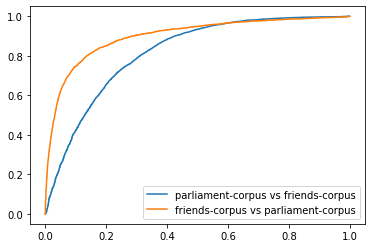

In [89]:
x = np.concatenate([ll1_f1, ll2_f1])
y = np.concatenate([np.ones_like(ll1_f1), np.zeros_like(ll2_f1)]).astype(int)
fpr, tpr, thresholds = metrics.roc_curve(y, x)
plt.plot(fpr, tpr, label=f'{s1} vs {s2}')
print(metrics.roc_auc_score(y, x))
x = np.concatenate([ll2_f2, ll1_f2])
y = np.concatenate([np.ones_like(ll2_f2), np.zeros_like(ll1_f2)]).astype(int)
fpr, tpr, thresholds = metrics.roc_curve(y, x)
plt.plot(fpr, tpr, label=f'{s2} vs {s1}')
print(metrics.roc_auc_score(y, x))
plt.legend()

In [ ]:
# TODO: train-test split
# TODO: one sided vocabulary ? - I guess it is, because 0-frequencies

0.9163437849785222
0.949782903303682


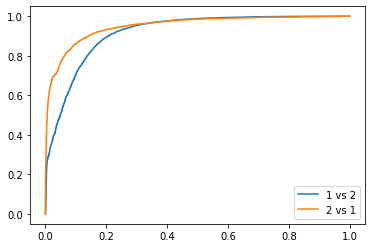

In [92]:
x = np.concatenate([ll1_f1 - ll1_general, ll2_f1 - ll2_general])
y = np.concatenate([np.ones_like(ll1_f1), np.zeros_like(ll2_f1)]).astype(int)
fpr, tpr, thresholds = metrics.roc_curve(y, x)
plt.plot(fpr, tpr, label='1 vs 2')
print(metrics.roc_auc_score(y, x))
x = np.concatenate([ll2_f2 - ll2_general, ll1_f2 - ll1_general])
y = np.concatenate([np.ones_like(ll2_f2), np.zeros_like(ll1_f2)]).astype(int)
fpr, tpr, thresholds = metrics.roc_curve(y, x)
plt.plot(fpr, tpr, label='2 vs 1')
print(metrics.roc_auc_score(y, x))
plt.legend()

## Baseline 2: OOV

In [17]:
friends = Corpus(filename=download("friends-corpus"))
# supreme = Corpus(filename=download("supreme-corpus"))
# # parliament = Corpus(filename=download("parliament-corpus"))
# movie = Corpus(filename=download("movie-corpus"))
# diplomacy = Corpus(filename=download("diplomacy-corpus")) # game, written
# switchboard = Corpus(filename=download("switchboard-corpus")) # conversational, from spoken
# reddit = Corpus(filename=download('reddit-corpus-small'))
# tennis = Corpus(filename=download('tennis-corpus'))

Dataset already exists at /Users/janek/.convokit/downloads/friends-corpus


In [284]:

import torch
import torch.nn as nn

In [287]:
g